In [1]:
from pydmd import BOPDMD
from pydmd.preprocessing import hankel_preprocessing
from pydmd.plotter import plot_summary
from signal_generator import SignalGenerator
from matplotlib import pyplot as plt
import numpy as np

In [2]:
signal_generator = SignalGenerator(x_min=-5, x_max=5, t_max=60)
signal_generator.add_sinusoid1(omega=0.5, k=1.5)
signal_generator.add_sinusoid2(omega=2.5)
signal_generator.add_sinusoid3(omega=5)
signal_generator.add_noise(random_seed=42)

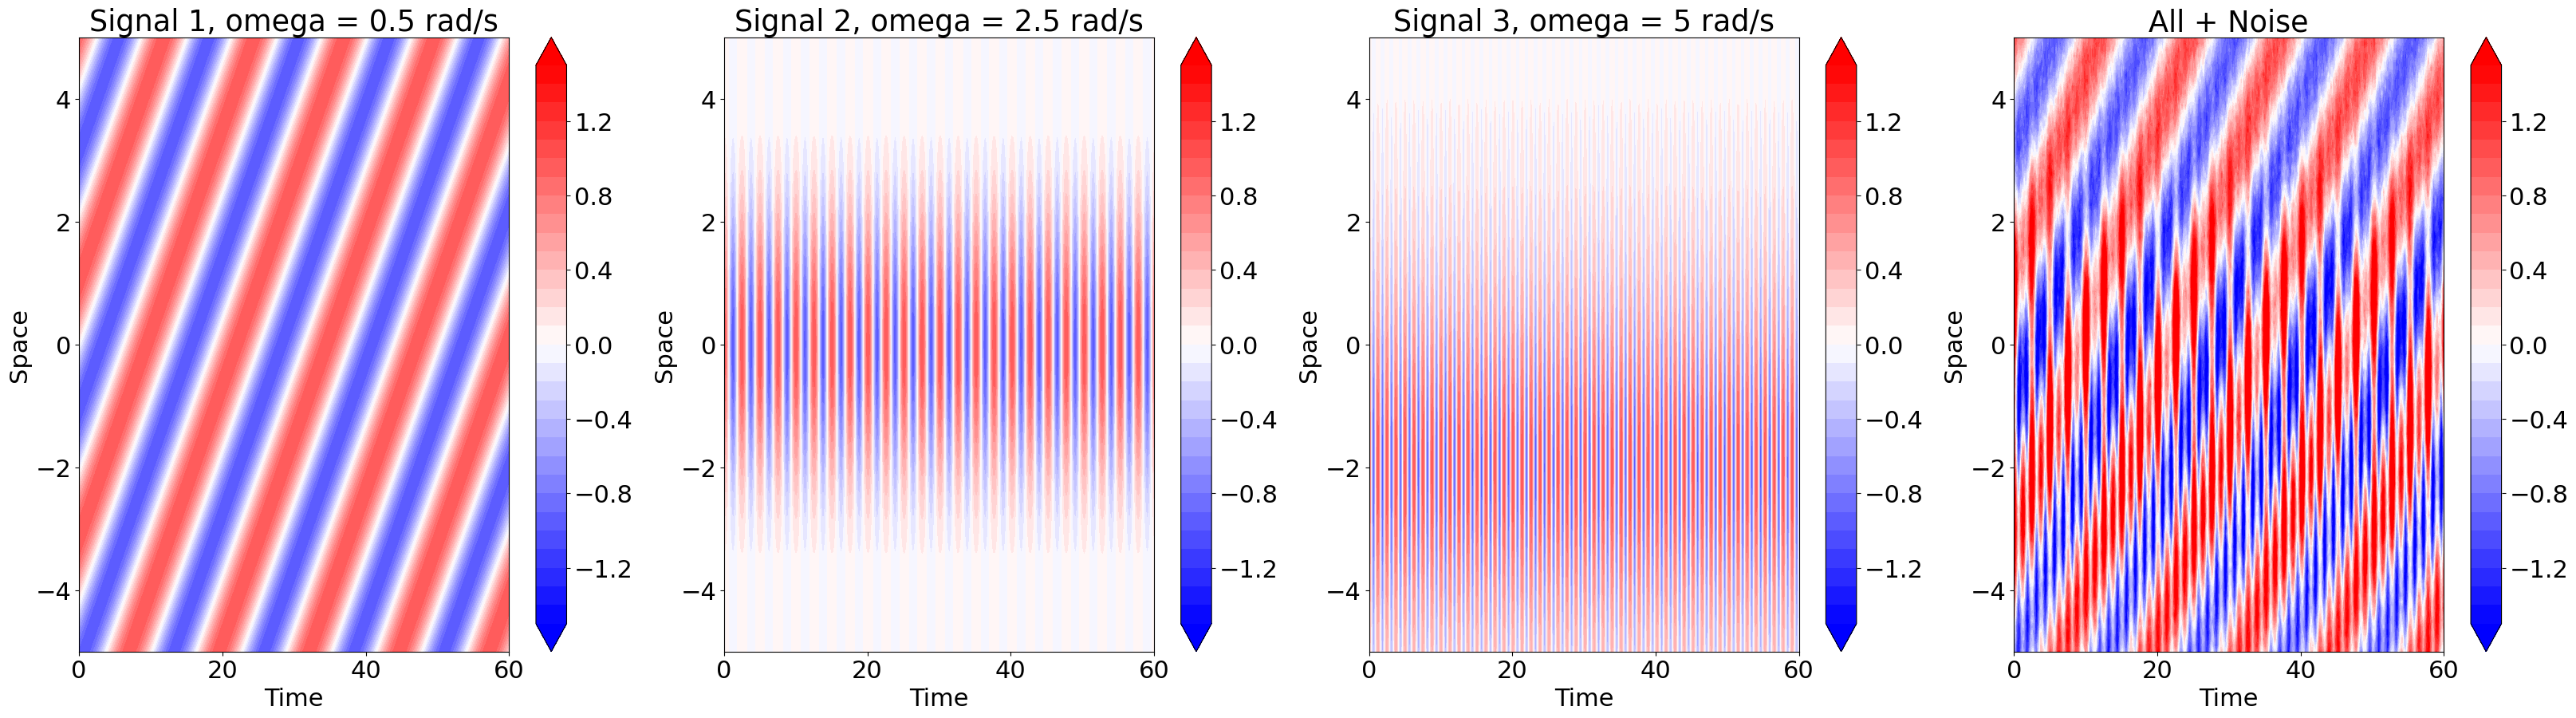

In [5]:
plt.rcParams.update({'font.size': 22})

fig = plt.figure(figsize=(40, 10))

vmin = -1.5; vmax = 1.5
levels = np.arange(vmin, vmax+0.1, 0.1)

ax = fig.add_subplot(1, 4, 1)
contour = ax.contourf(signal_generator.T, signal_generator.X, signal_generator.components[0]["signal"], levels=levels, cmap='bwr', extend='both')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title(f'Signal 1, omega = {signal_generator.components[0]["omega"]} rad/s')
plt.colorbar(contour, ax=ax, orientation="vertical")

ax = fig.add_subplot(1, 4, 2)
contour = ax.contourf(signal_generator.T, signal_generator.X, signal_generator.components[1]["signal"], levels=levels, cmap='bwr', extend='both')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title(f'Signal 2, omega = {signal_generator.components[1]["omega"]} rad/s')
plt.colorbar(contour, ax=ax, orientation="vertical")

ax = fig.add_subplot(1, 4, 3)
contour = ax.contourf(
    signal_generator.T, signal_generator.X, signal_generator.components[2]["signal"], levels=levels, cmap='bwr', extend='both'
    )
plt.xlabel('Time')
plt.ylabel('Space')
plt.title(f'Signal 3, omega = {signal_generator.components[2]["omega"]} rad/s')
plt.colorbar(contour, ax=ax, orientation="vertical")

ax = fig.add_subplot(1, 4, 4)
contour = ax.contourf(signal_generator.T, signal_generator.X, signal_generator.signal, levels=levels, cmap='bwr', extend='both')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title('All + Noise')
plt.colorbar(contour, ax=ax, orientation="vertical")

plt.show()

In [6]:
svd_rank = 6
delay = 2

In [7]:
optdmd = BOPDMD(svd_rank=svd_rank, num_trials=0, use_proj=True)
delay_optdmd = hankel_preprocessing(optdmd, d=delay)

In [8]:
# fit DMD model to 80% of the data
train_frac = 0.8
f_train = signal_generator.signal[:int(train_frac * signal_generator.signal.shape[0]), :]
t_train = signal_generator.t[:int(train_frac * signal_generator.signal.shape[0])]
f_test = signal_generator.signal[int(train_frac * signal_generator.signal.shape[0]):, :]
t_test = signal_generator.t[int(train_frac * signal_generator.signal.shape[0]):]

In [9]:
t_delay = t_train[:-delay+1]
delay_optdmd.fit(f_train.T, t=t_delay)
delay_optdmd.fit(f_train.T, t=t_delay)

/Users/dsalvadorjasin/Documents/projects/MetOffice/DMD/toy_dataset/.venv/lib/python3.10/site-packages/pydmd/bopdmd.py:751: UserWarning: Initial trial of Optimized DMD failed to converge. Consider re-adjusting your variable projection parameters with the varpro_opts_dict and consider setting verbose=True.
  warnings.warn(msg)


In [10]:
t_delay = t_train[:-delay+1]
delay_optdmd.fit(f_train.T, t=t_delay)

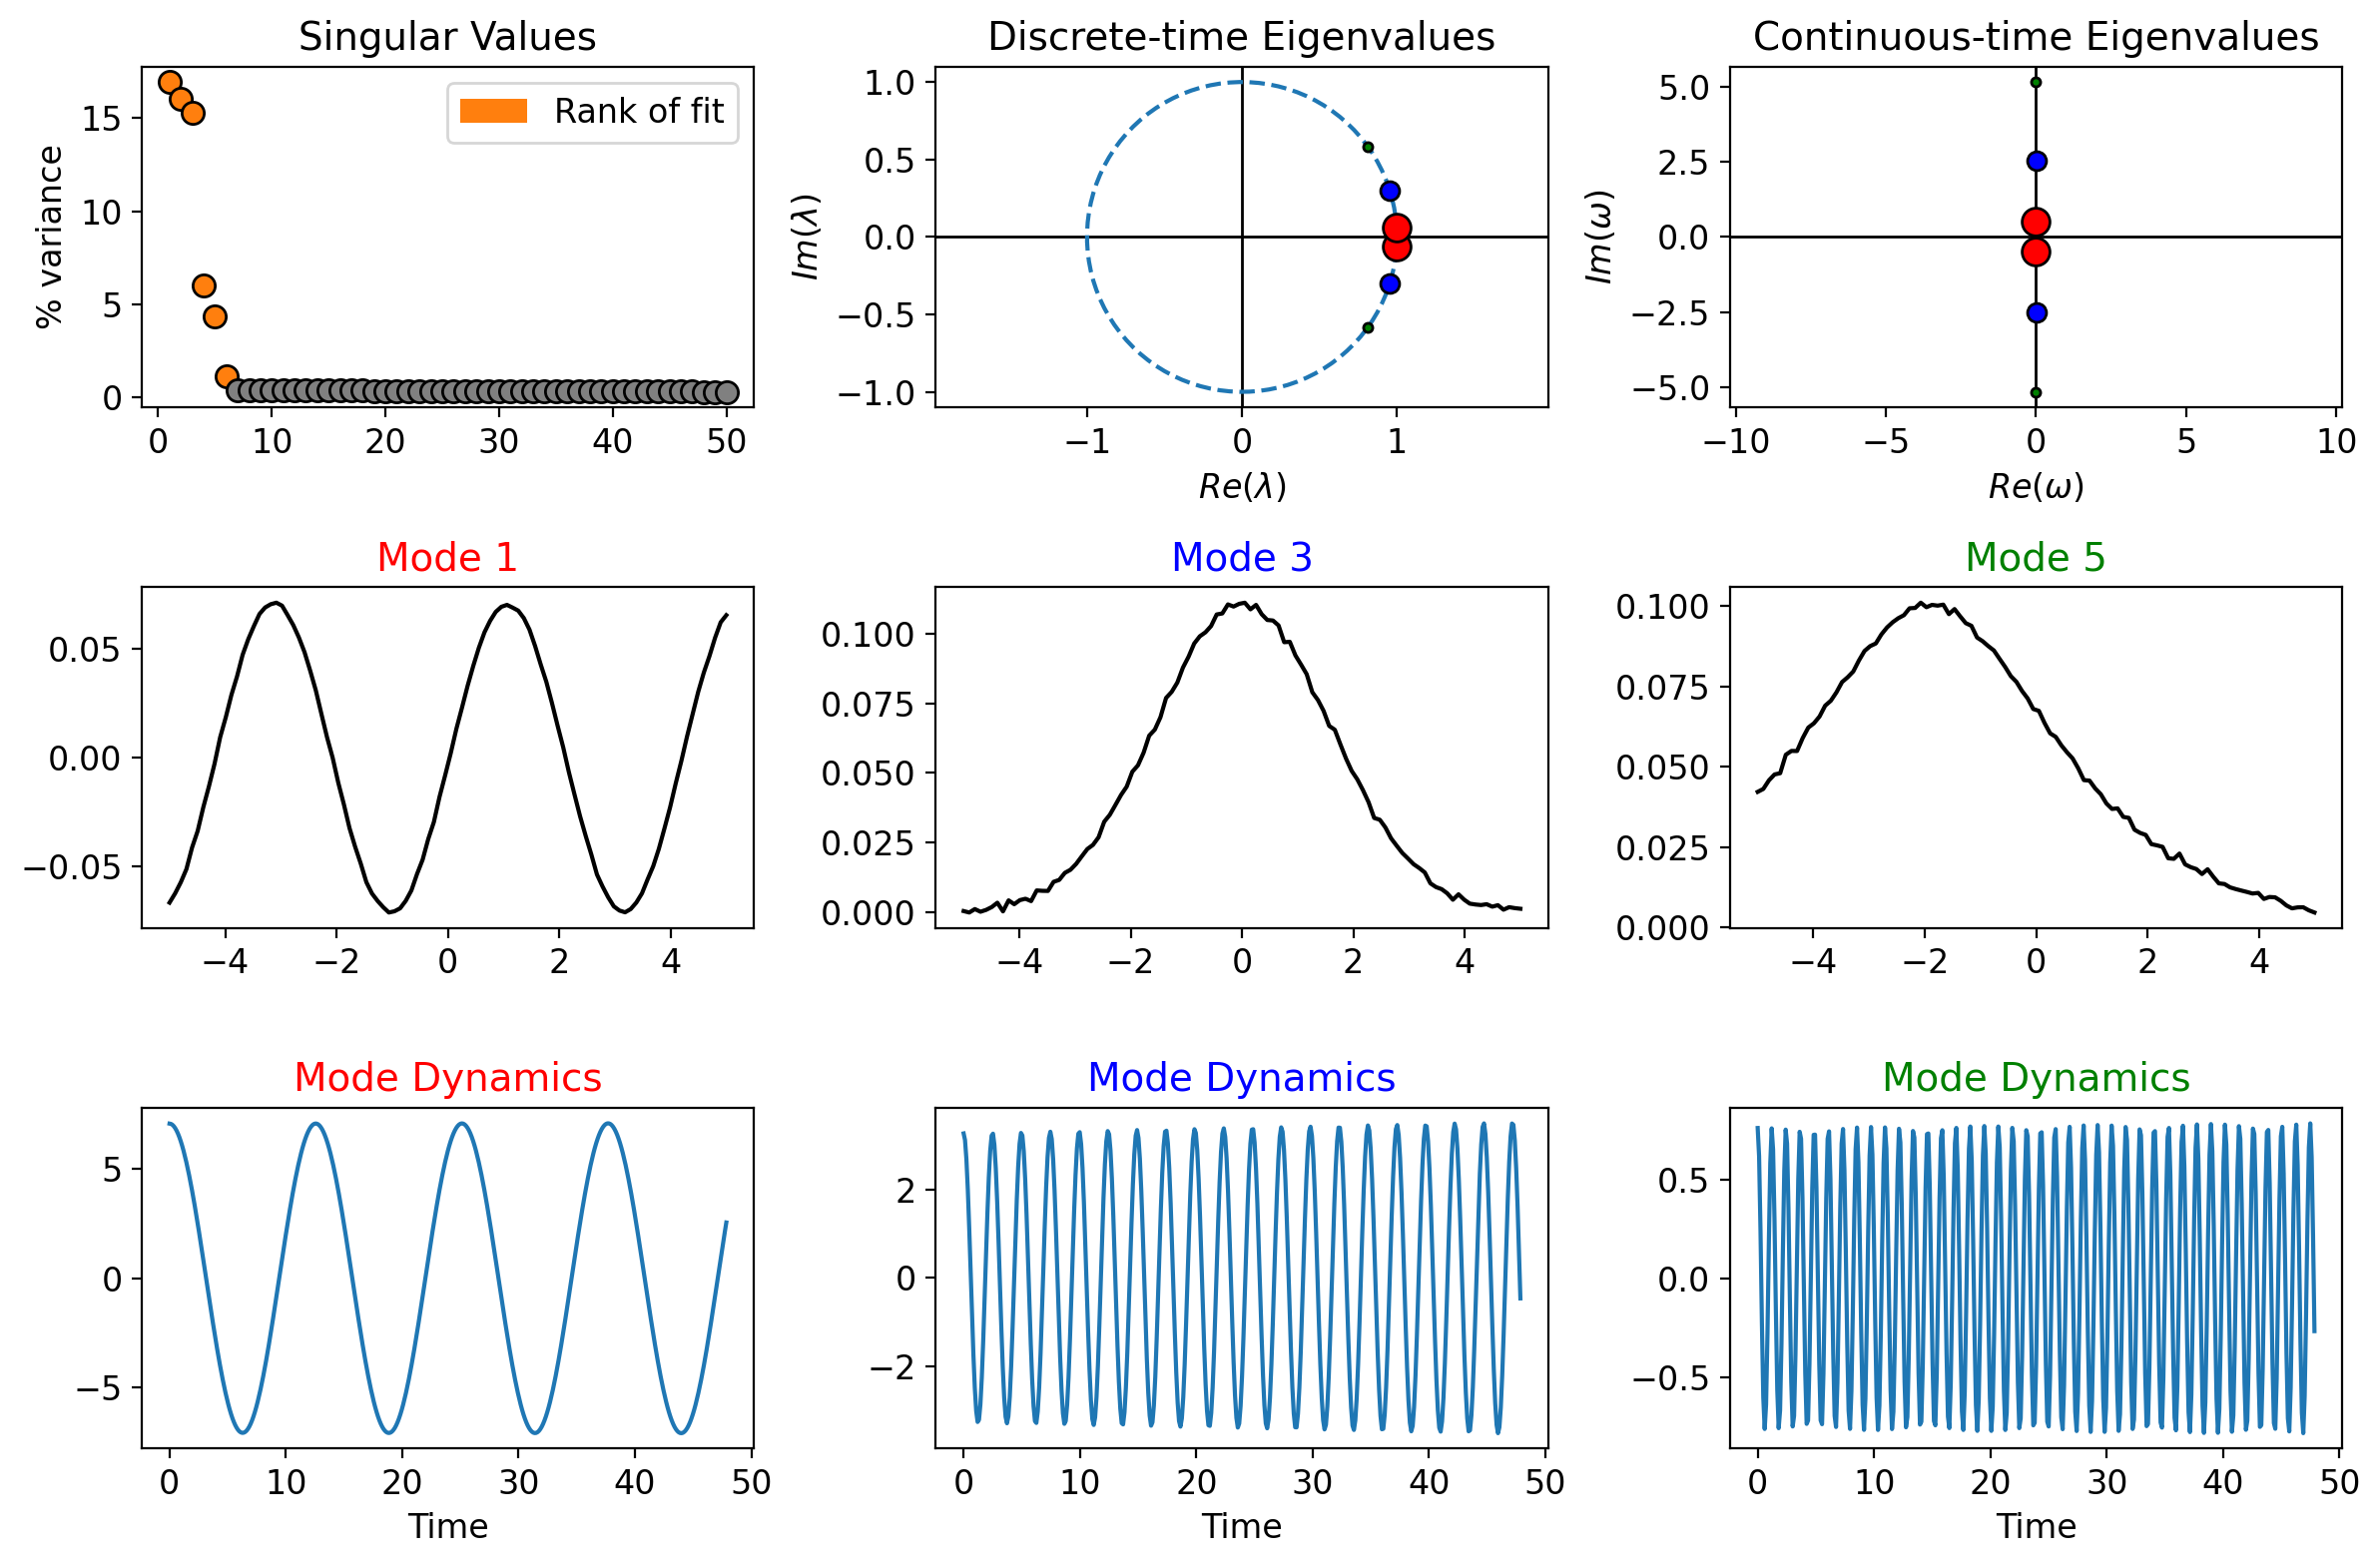

In [11]:
plt.rcParams.update({'font.size': 12})
plot_summary(delay_optdmd, x=signal_generator.x, d=delay, index_modes=[0, 2, 4])

In [12]:
sorted_index = np.argsort(delay_optdmd.amplitudes)[::-1]
print(f"Amplitudes: {delay_optdmd.amplitudes[sorted_index]}")
print(f"Eigenvalues: {delay_optdmd.eigs[sorted_index]}")

Amplitudes: [7.06463878 7.06463878 3.26547993 3.26547993 0.76264163 0.76264163]
Eigenvalues: [5.52661050e-05-0.50003758j 5.52661050e-05+0.50003758j
 1.56939578e-03+2.53017195j 1.56939578e-03-2.53017195j
 6.70281440e-04-5.1605194j  6.70281440e-04+5.1605194j ]


In [14]:
eigs = delay_optdmd.eigs[sorted_index]
modes = delay_optdmd.modes[:, sorted_index]
dynamics = delay_optdmd.dynamics[sorted_index, :]
amps = delay_optdmd.amplitudes[sorted_index]

In [13]:
def reconstruct(mode, eig, amp, t=t_train, x_lim=signal_generator.x.shape[0]):
    reconstruction = np.linalg.multi_dot([mode.reshape(-1, 1), np.diag([amp]), np.exp(np.outer(eig, t))]).real
    reconstruction = reconstruction[:x_lim, :]
    return reconstruction

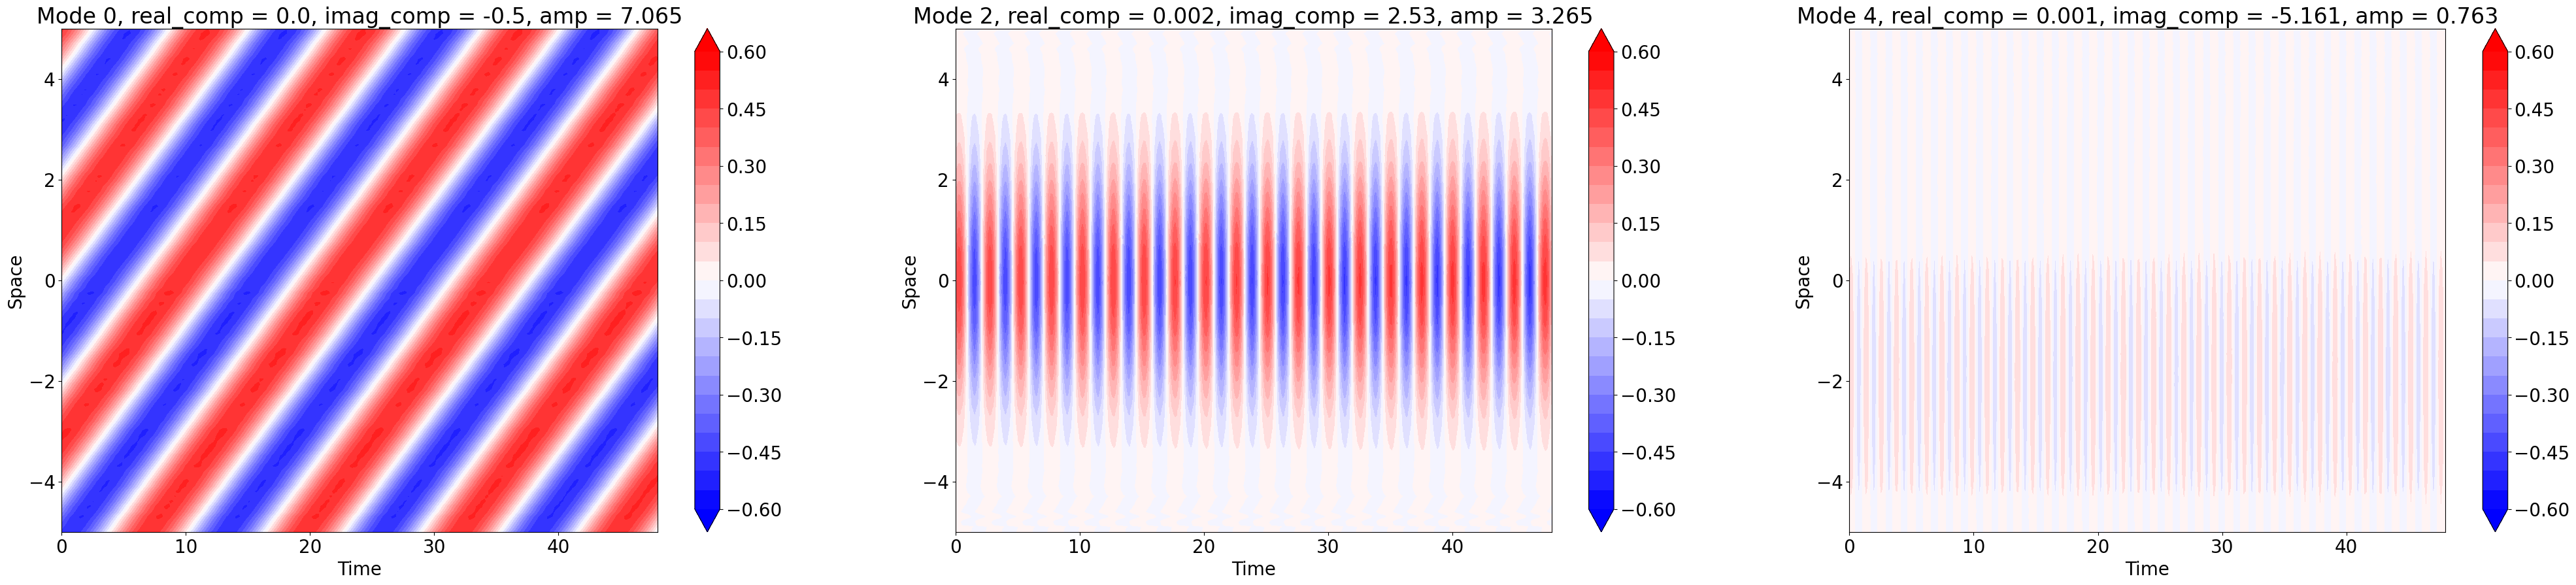

In [16]:
# plot contours of the reconstructed data from each mode
# these should ideally be the same as the individual signals that compose the data

plt.rcParams.update({'font.size': 20}) 

fig = plt.figure(figsize=(50, 10))

which_modes = [0, 2, 4]

vmin = -0.6; vmax = 0.6
levels = np.arange(vmin, vmax+0.05, 0.05)

X, T = np.meshgrid(signal_generator.x, t_train)


ax = fig.add_subplot(1, 3, 1)
reconstruction = reconstruct(modes[:, which_modes[0]], eigs[which_modes[0]], amps[which_modes[0]])
contour = ax.contourf(T, X, reconstruction.T, levels=levels, cmap='bwr', extend='both')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title(f'Mode {which_modes[0]}, real_comp = {np.round(eigs[which_modes[0]].real, 3)}, imag_comp = {np.round(eigs[which_modes[0]].imag, 3)}, amp = {np.round(amps[which_modes[0]], 3)}')
plt.colorbar(contour, ax=ax, orientation="vertical")

ax = fig.add_subplot(1, 3, 2)
reconstruction = reconstruct(modes[:, which_modes[1]], eigs[which_modes[1]], amps[which_modes[1]])
contour = ax.contourf(T, X, reconstruction.T, levels=levels, cmap='bwr', extend='both')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title(f'Mode {which_modes[1]}, real_comp = {np.round(eigs[which_modes[1]].real, 3)}, imag_comp = {np.round(eigs[which_modes[1]].imag, 3)}, amp = {np.round(amps[which_modes[1]], 3)}')
plt.colorbar(contour, ax=ax, orientation="vertical")

ax = fig.add_subplot(1, 3, 3)
reconstruction = reconstruct(modes[:, which_modes[2]], eigs[which_modes[2]], amps[which_modes[2]])
contour = ax.contourf(T, X, reconstruction.T, levels=levels, cmap='bwr', extend='both')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title(f'Mode {which_modes[2]}, real_comp = {np.round(eigs[which_modes[2]].real, 3)}, imag_comp = {np.round(eigs[which_modes[2]].imag, 3)}, amp = {np.round(amps[which_modes[2]], 3)}')
plt.colorbar(contour, ax=ax, orientation="vertical")


In [17]:
forecast = delay_optdmd.forecast(t_test)
forecast = forecast[:signal_generator.x.shape[0], :]  # note than need to do this because of the time delay embedding
forecast = forecast.T
forecast = forecast.real

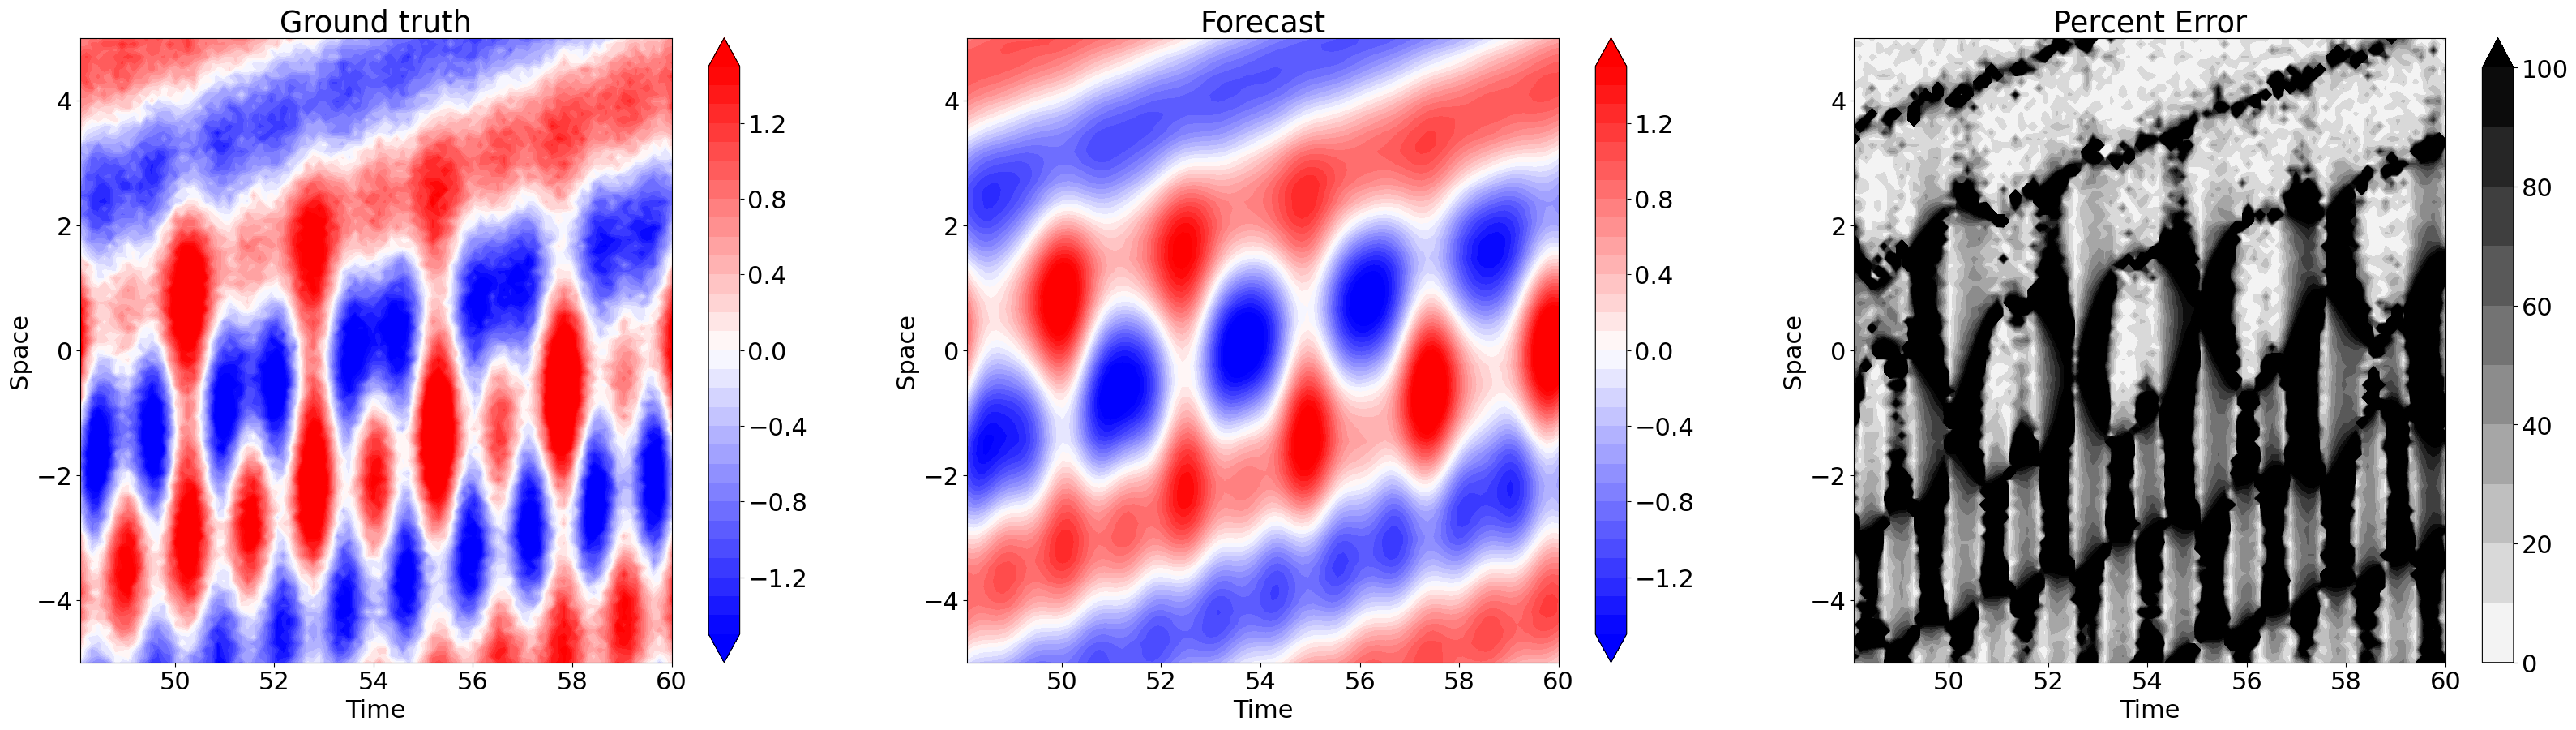

In [18]:
# compare the forecast to the ground truth

plt.rcParams.update({'font.size': 22})

X, T = np.meshgrid(signal_generator.x, t_test) 

fig = plt.figure(figsize=(40, 10))

vmin = -1.5; vmax = 1.5
levels = np.arange(vmin, vmax+0.1, 0.1)

ax = fig.add_subplot(1, 3, 1)
contour = ax.contourf(T, X, f_test, levels=levels, cmap='bwr', extend="both")
plt.xlabel('Time')
plt.ylabel('Space')
plt.title("Ground truth")
plt.colorbar(contour, ax=ax, orientation="vertical")

ax = fig.add_subplot(1, 3, 2)
contour = ax.contourf(T, X, forecast, levels=levels, cmap='bwr', extend="both")
plt.xlabel('Time')
plt.ylabel('Space')
plt.title('Forecast')
plt.colorbar(contour, ax=ax, orientation="vertical")

# plot the percent error
percent_error = np.abs(f_test - forecast) / np.abs(f_test) * 100
ax = fig.add_subplot(1, 3, 3)
contour = ax.contourf(T, X, percent_error, levels=np.arange(0, 101, 10), cmap='gray_r', extend="max")
plt.xlabel('Time')
plt.ylabel('Space')
plt.title('Percent Error')
plt.colorbar(contour, ax=ax, orientation="vertical")

plt.show()